# **AlexNet(2012) code 구현**


모델 아키텍처

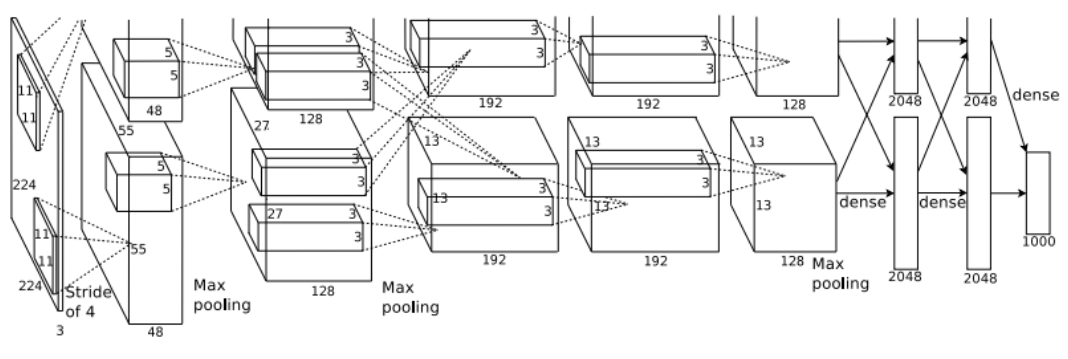

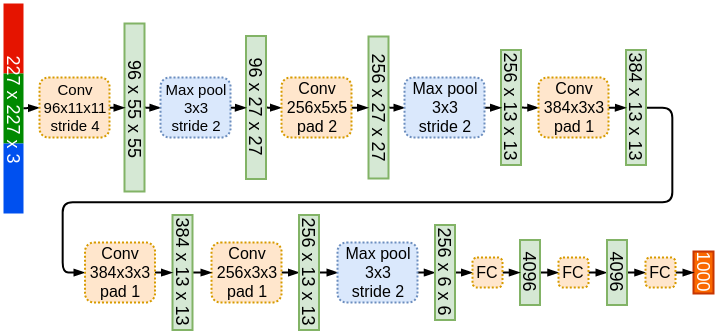

# PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device   # cuda 지정

device(type='cuda')

In [5]:
# 논문 5. Details of learning 참고 parameter
batch_size = 128
momentum = 0.9
lr_decay = 0.0005
lr_init = 0.01
image_dim = 227    # pixels
num_classes = 1000   # 1000개의 class 지정
device_ids = [0, 1, 2, 3]

In [15]:
class AlexNet(nn.Module):

  def __init__(self, num_classes=1000):
    super().__init__()

    ##### CNN layers 
    self.net = nn.Sequential(
        # conv1
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),  # non-saturating function
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # 논문의 LRN 파라미터 그대로 지정
        nn.MaxPool2d(kernel_size=3, stride=2),
        # conv2
        nn.Conv2d(96, 256, kernel_size=5, padding=2), 
        nn.ReLU(inplace=True),
        nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
        nn.MaxPool2d(kernel_size=3, stride=2),
        # conv3
        nn.Conv2d(256, 384, 3, padding=1),
        nn.ReLU(inplace=True),
        # conv4
        nn.Conv2d(384, 384, 3, padding=1),
        nn.ReLU(inplace=True),
        # conv5
        nn.Conv2d(384, 256, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),

    )

    ##### FC layers
    self.classifier = nn.Sequential(
        # fc1
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
        nn.ReLU(inplace=True).
        # fc2
        nn.Dropout(p=0.5, inplace=True),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )

    # bias, weight 초기화 
    def init_bias_weights(self):
      for layer in self.net:
        if isinstance(layer, nn.Conv2d):
          nn.init.normal_(layer.weight, mean=0, std=0.01)   # weight 초기화
          nn.init.constant_(layer.bias, 0)   # bias 초기화

      # conv 2, 4, 5는 bias 1로 초기화 
      nn.init.constant_(self.net[4].bias, 1)
      nn.init.constant_(self.net[10].bias, 1)
      nn.init.constant_(self.net[12].bias, 1)

    # modeling 
    def forward(self, x):
      x = self.net(x)   # conv
      x = x.view(-1, 256*6*6)   # keras의 reshape (텐서 크기 2d 변경)
      return self.classifier(x)   # fc   

In [13]:
if __name__== '__main__':
  seed = torch.initial_seed()  # seed value 설정
  model = AlexNet(num_classes=num_classes).to(device)
  model = torch.nn.parallel.DataParallel(model, divice_ids=device_ids)  # 모델 설정
  print(model)

  # dataset, data loader 설정
  dataset = datasets.ImageFolder(TRAIN_IMG_DIR, transforms.Compose([
      transforms.CenterCrop(IMAGE_DIM),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ]))

  dataloader = data.DataLoader(
      dataset,
      shuffle=True,
      pin_memory=True,
      num_workers=8,
      drop_last=True,
      batch_size=batch_size)

  # optimizer
  optimizer = optim.SGD(
      params = model.parameters(),
      lr = lr_init,
      momentum = momentum,
      weight_decay = lr_decay  # lr 점점 감소
  )

  lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)   # lr 점점 감소

  # training
  total_steps=1
  for epoch in range(num_epochs):
    lr_scheduler.step()

    for imgs, classes in dataloader:
      imgs, classes = imgs.to(device), classes.to(device)

      output = alexnet(imgs)
      loss = F.cross_entropy(output, classes)  # loss 계산

      optimizer.zero_grad()
      loss.backward()  # backpropa
      optimizer.step()  # parameter update

# Keras

In [18]:
pip install tensorboardcolab   # tensorboard 설치

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-cp37-none-any.whl size=3858 sha256=d34ac6397777803c58800615801301b63f79b7d05d970e91d775a67acb822ca4
  Stored in directory: /root/.cache/pip/wheels/c4/aa/a0/3aaf4f1a66adbdab9b7bdd4c96db8ada89eb7cd87200cfdd32
Successfully built tensorboardcolab


In [3]:
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback, TensorBoard
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from sklearn.preprocessing import LabelBinarizer
from tensorflow.nn import local_response_normalization  # lrn

In [31]:
# modeling(functional API)
input_shape = (224, 224, 3)  # 논문에서 제시된 shape
x = Input(shape = input_shape, name='INPUT')

# CONV
conv1 = Conv2D(filters=96, kernel_size=11, activation='relu', strides=4, name='CONV_1')(x)
pool1 = MaxPooling2D((3,3), strides=2, name='POOL_1')(conv1)  # overlapped pooling
# lrn1 = local_response_normalization(conv1,depth_radius=5, bias=2, alpha=0.0001, beta=0.75) 
lrn1 = BatchNormalization(name='LRN_1')(pool1)

conv2 = Conv2D(filters=256, kernel_size=5, activation='relu', strides=1, padding='same', name='CONV_2')(lrn1)
pool2 = MaxPooling2D((3,3), strides=2, name='POOL_2')(conv2)
# lrn2 = local_response_normalization(conv2,depth_radius=5, bias=2,  alpha=0.0001, beta=0.75)
lrn2 = BatchNormalization(name='LRN_2')(pool2)

conv3 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_3')(lrn2)
conv4 = Conv2D(filters=384, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_4')(conv3)
conv5 = Conv2D(filters=256, kernel_size=3, activation='relu', strides=1, padding='same', name='CONV_5')(conv4)
pool3 = MaxPooling2D((3,3), strides=2, name='POOL_3')(conv5)

# FC
f = Flatten()(pool3)
f = Dense(4096, activation='relu', name='FC_1')(f)
f = Dropout(0.5)(f)  # 논문 parameter 0.5 이용
f = Dense(4096, activation='relu', name='FC_2')(f)
f = Dropout(0.5)(f)
out = Dense(1000, activation='softmax', name='OUTPUT')(f)

model = Model(inputs=x, outputs=out)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
CONV_1 (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 26, 26, 96)        0         
_________________________________________________________________
LRN_1 (BatchNormalization)   (None, 26, 26, 96)        384       
_________________________________________________________________
CONV_2 (Conv2D)              (None, 26, 26, 256)       614656    
_________________________________________________________________
POOL_2 (MaxPooling2D)        (None, 12, 12, 256)       0         
_________________________________________________________________
LRN_2 (BatchNormalization)   (None, 12, 12, 256)       1024

# CIFAR10 data 적용

In [29]:
# cifar10 data load
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

In [30]:
x_train.shape

(50000, 32, 32, 3)

In [31]:
print(img_height, img_width)   # 224*224 가 아닌 32*32임

32 32


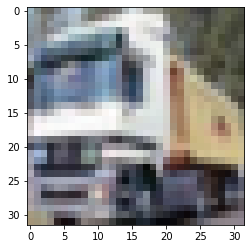

In [32]:
plt.imshow(x_train[1])   # 10개의 물체가 있는 data

In [33]:
batch_size = 128
num_classes = 10
epochs = 10

y_train = to_categorical(y_train, num_classes)  # category화 
y_test = to_categorical(y_test, num_classes)

model = Sequential()
# model.add(Conv2D(96, (11,11), strides=(4,4), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
# for original Alexnet
model.add(Conv2D(48, (3,3), strides=(2,2), activation='relu', padding='same', input_shape=(img_height, img_width, channel,)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(96, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(192, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2,2)))
# Local Response normalization for Original Alexnet
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


In [34]:
y_train.shape

(50000, 10)

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10, 
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
391/391 [==============================] - 4s 8ms/step - loss: 1.5372 - accuracy: 0.4572 - val_loss: 1.6882 - val_accuracy: 0.4493
Epoch 2/10
391/391 [==============================] - 3s 7ms/step - loss: 1.0905 - accuracy: 0.6217 - val_loss: 1.2006 - val_accuracy: 0.5859
Epoch 3/10
391/391 [==============================] - 3s 7ms/step - loss: 0.9039 - accuracy: 0.6891 - val_loss: 0.9763 - val_accuracy: 0.6641
Epoch 4/10
391/391 [==============================] - 3s 7ms/step - loss: 0.7717 - accuracy: 0.7369 - val_loss: 0.8789 - val_accuracy: 0.6967
Epoch 5/10
391/391 [==============================] - 3s 7ms/step - loss: 0.6724 - accuracy: 0.7737 - val_loss: 0.9019 - val_accuracy: 0.6975
Epoch 6/10
391/391 [==============================] - 3s 7ms/step - loss: 0.5882 - accuracy: 0.8022 - val_loss: 1.0472 - val_accuracy: 0.6699
Epoch 7/10
391/391 [==============================] - 3s 7ms/step - loss: 0.5114 - accuracy: 0.8276 - val_loss: 0.9927 - val_accuracy: 0.6894
Epoch 

In [37]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
predictions = model.predict(x_test, verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 1.0321 - accuracy: 0.7136
Test loss: 1.0321128368377686
Test accuracy: 0.7135999798774719
313/313 [==============================] - 1s 2ms/step


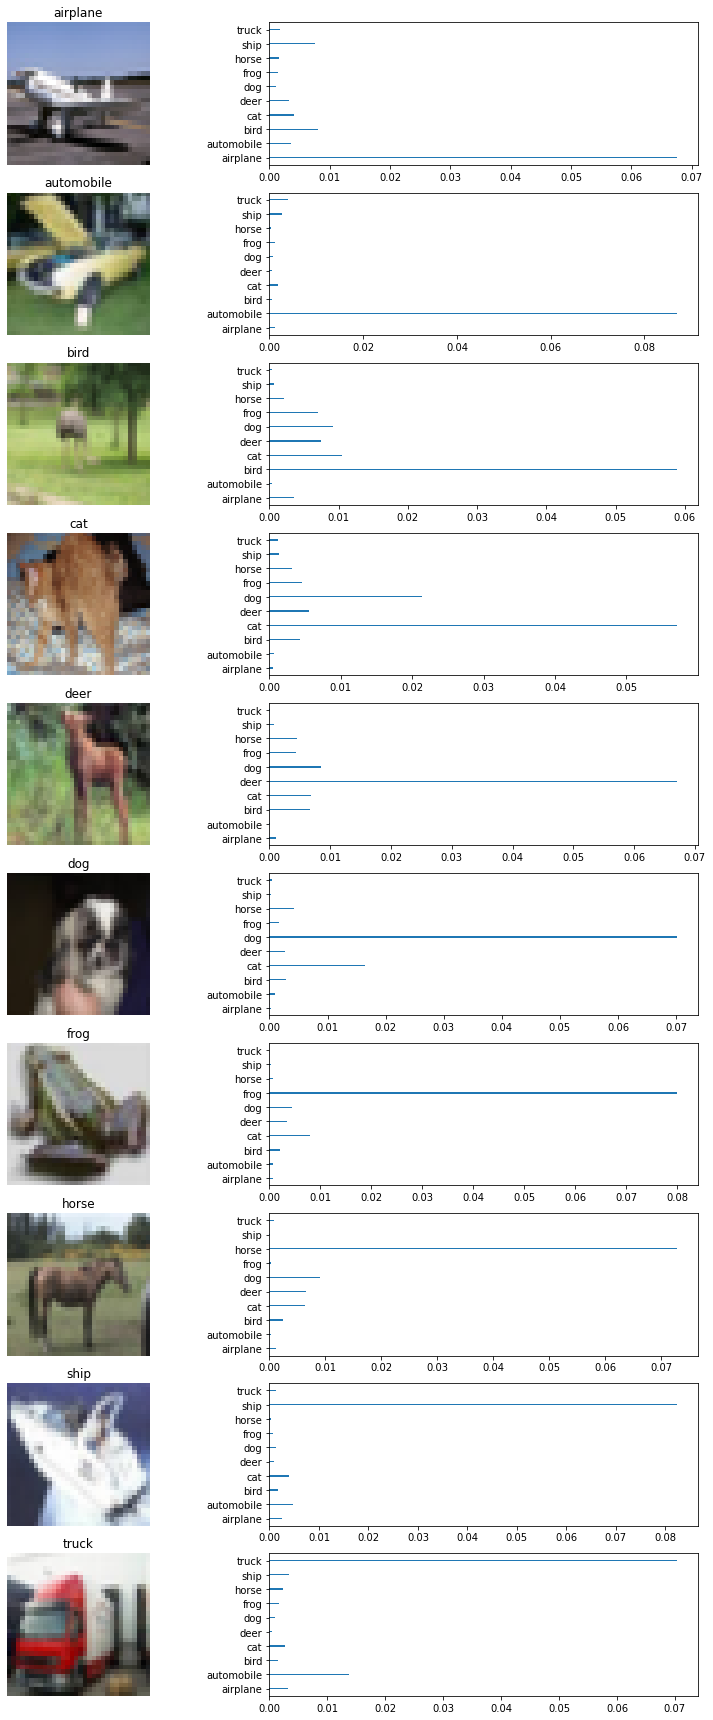

In [38]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axs = plt.subplots(10, 2, figsize=(12,24))
    margin = 0.05
    ind = np.arange(n_classes)
    width = (1. - 2. * margin) / n_classes    
    arr_features = [None]*10
    arr_predictions = np.zeros((10, 10))
    last_image_i = 0
    
    for i, prediction in enumerate(predictions):
        label_id = label_ids[i]
        feature = features[i]
        arr_features[label_id] = feature
        max_id = np.argmax(prediction)
        arr_predictions[label_id][max_id] += 1
        last_image_i = i

    arr_predictions /= last_image_i
    
    for i in range(10):
      feature = arr_features[i]
      pred_name = label_names[i]
      prediction = arr_predictions[i]
      axs[i][0].imshow(feature)
      axs[i][0].set_title(pred_name)
      axs[i][0].set_axis_off()

      axs[i][1].barh(ind + margin, prediction, width)
      axs[i][1].set_yticks(ind + margin)
      axs[i][1].set_yticklabels(label_names)

    plt.tight_layout()

display_image_predictions(x_test, y_test, predictions)